In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.fftpack import fft, ifft

In [3]:
def Window(ts):
    '''This function applies a parabolic window to the signal input'''
    n = len(ts)
    W = np.zeros((n,1))
    #create parabola from 0 to length n
    for j in np.arange(0,n):
        W[j] = 1 - np.power((2*(j + 1)/(n+1)-1),2)
    #multiply parabola and signal to get result  
    result = ts * W
    return result

def Bridge(ts):
    '''This function applies the bridge detrended method to the signal input'''
    n = len(ts)
    #points is the length of the time series from n-1 to 0 (backwords)
    points = np.arange(n-1, -1, -1).reshape(1,n)
    #line connecting first and last point
    line = ((ts[0]-ts[n-1])*points/(n-1))+ts[n-1]
    line = line.transpose()
    #subtract line from time series
    result = ts - line
    return result 

def Spec(ts, p, avg): 
    '''This function performs a spectral analysis of the time series
    where ts is the time series, p is the nth power of 2 where 2^n<=length
    of time series. If avg=0, then spectra for all, if avg=1, then spectra avg.
    result(1): Hurst coefficient
    result(2): correlation coefficient
    result(3): beta from Fourier analysis
    result(4): Hurst coefficient (high freq excluded)
    result(5): correlation coefficient (high freq excluded)
    result(6): beta from Fourier analysis (high freq excluded)'''
    
    f = 1
    n = 2**p
    #compute the discrete fourier transform of time series 
    Y = scipy.fftpack.fft(ts.flatten())
    #divide the conjucate of the FFT by n
    Pyy = Y*np.divide(Y.conj(),n)
    #splice array to only include have first half 
    Pyy = Pyy[0:int(n/2)]

    plt.plot(Pyy)

    
    
def FracTool(ts):
    '''This function will aid time series analysis using the concept 
     of statistical fractals.
     This code is adapted from A. Eke, P. Hermán, J. B. Bassingthwaighte, G. M. Raymond, D. B. Percival, 
     M. Cannon, I. Balla, and C. Ikrényi. Physiological time series: distinguishing 
     fractal noises from motions. Pflügers Archiv European Journal of 
     Physiology,4394):403-415, 2000. 
     Fractool determines: 
     1) The signal class of the time series according to the fGn/fBm model
     2) The Hurst coefficients for the fGn or fBm time series
     The input ts is a time series of a single coloumn of data points
    '''
    assert (len(ts) !=0), 'time series is empty'
    
    #INITIALIZATION 
    H_PSD = -1
    H_Disp = -1
    H_bdSWV = -1
    H_fGn = -1
    H_fBm = -1
    
    #PARAMETERS
    n=len(ts) #length of time series input
    print('Number of timepoints = ', n)
    i = 1
    while n >= 2**i: #calculates the closest 2^i value in n 
        i += 1
    p = i - 1
    tsid = ts[0:2**p] #splices ts to exclue points after 2^i
    print('Number of timepoints after 2^p splice =', 2**p)
    del ts #delete signal before splice
    signal_mean = np.mean(tsid) #get mean of tsid
    print('Mean of time series = ', signal_mean)
    n = len(tsid) #update n to length of tsid
    
    #GET BETA USING lowPSDw,e METHOD
    result = Spec(Bridge(Window(tsid)),p,0)

Number of timepoints =  1024
Number of timepoints after 2^p splice = 1024
Mean of time series =  -23.59470008156738


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


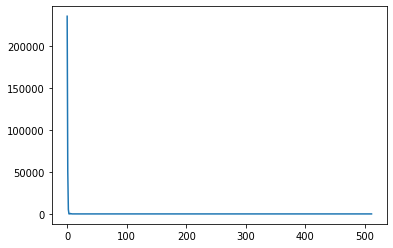

In [5]:
#Loads fbm signal of known Hurst coeffecient 
#Hurst coeff is 0.7 and signal has 1024 timepoints
fBm_test_signal = np.loadtxt(fname="fBm_signal_test.csv", delimiter=",")
#make 1D array 2D and transpose so single column vector 
fBm_transposed = np.reshape(fBm_test_signal,(fBm_test_signal.size, 1))
#function call
FracTool(fBm_transposed)